In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score,recall_score
import pickle

In [2]:
df = pd.read_csv("health_data.csv")

dataset found here: 
https://www.kaggle.com/datasets/prosperchuks/health-dataset <br>
Targets are Diabetes, Hypertension, Stroke. <br>
From dataset description in kaggle: <br>
"This is a clean dataset of over 70,692 survey responses to the CDC's BRFSS2015. There are 18 feature variables and 3 target variables, Diabetes, Hypertension, and Stroke, each target variable having 2 classes. This dataset is balanced."<br>
The description is partly wrong wrt the last sentence - as far as the target Stroke is concerned, the dataset is highly imbalanced.<br>
Feature descriptions: <br>
1. 13-level age category <br>1 = 18-24, 2 = 25-29, 3 = 30-34, 4 = 35-39, 5 = 40-44 <br> 6 = 45-49, 7 = 50-54, 8 = 55-59, 9 = 60-64, 10 = 65-69 <br> 11 = 70-74, 12 = 75-79, 13 = 80 or older
2. 0 = female, 1 = male
3. 0 = no high cholesterol, 1 = high cholesterol
4. 0 = no cholesterol check in 5 years, 1 = yes cholesterol check in 5 years
5. Body Mass Index (BMI)
6. Have you smoked at least 100 cigarettes in your entire life? (Note: 5 packs = 100 cigarettes) 0 = no, 1 = yes
7. coronary heart disease (CHD) or myocardial infarction (MI) 0 = no, 1 = yes
8. physical activity in past 30 days - not including job 0 = no, 1 = yes
9. Consume Fruit one or more times per day 0 = no, 1 = yes
10. Consume Vegetables 1 or more times per day 0 = no, 1 = yes
11. Adult male: more than 14 drinks per week. Adult female: more than 7 drinks per week. 0 = no, 1 = yes
12. Would you say that in general your health is: (scale 1-5) 1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor
13. days of poor mental health scale 1-30 days
14. physical illness or injury days in past 30 days scale 1-30
15. Do you have serious difficulty walking or climbing stairs? 0 = no, 1 = yes
16. 0 = no diabetes, 1 = diabetes
17. 0 = no hypertension, 1 = hypertension
18. 0 = no, 1 = yes (stroke)

In [3]:
df

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Diabetes,Hypertension,Stroke
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,6.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
70688,10.0,1.0,1.0,1.0,29.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0
70689,13.0,0.0,1.0,1.0,25.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,15.0,0.0,1.0,1.0,1.0,0.0
70690,11.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0


In [86]:
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Diabetes,Hypertension,Stroke
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.500000,0.563458,0.062171
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.500004,0.495960,0.241468
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,1.000000,0.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.shape

(70692, 18)

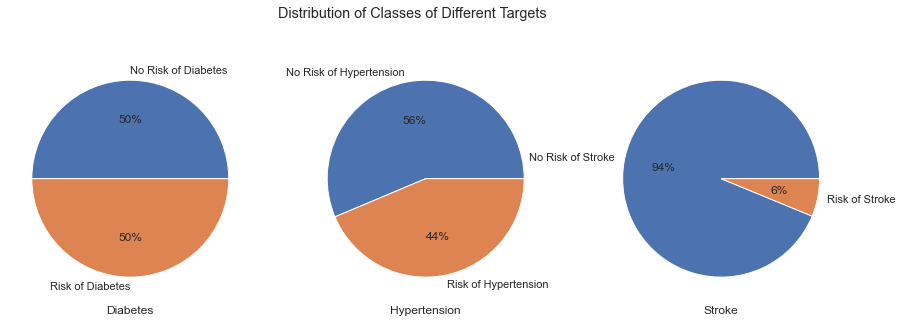

In [5]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
plt.suptitle("Distribution of Classes of Different Targets")
ax[0].pie(df['Diabetes'].value_counts(),labels=['No Risk of Diabetes','Risk of Diabetes'],autopct='%1.0f%%')
ax[0].set_xlabel("Diabetes")
ax[1].pie(df['Hypertension'].value_counts(),labels=['No Risk of Hypertension','Risk of Hypertension'],autopct='%1.0f%%')
ax[1].set_xlabel("Hypertension")
ax[2].pie(df['Stroke'].value_counts(),labels=['No Risk of Stroke','Risk of Stroke'],autopct='%1.0f%%')
ax[2].set_xlabel("Stroke")
plt.show()

## Data Analysis

In [6]:
targets=['Diabetes','Hypertension','Stroke']
features=df.columns.tolist()
features = list(set(features)-set(targets))

Although all features are numerical, on closer examination, a number of them are categorical(binary).

In [7]:
num_cols = list()
cat_cols = list()
for i in features:
    if(df[i].value_counts().index.shape[0] == 2):
        cat_cols.append(i)
    else:
        num_cols.append(i)

In [8]:
cat_cols #binary features

['Smoker',
 'Veggies',
 'DiffWalk',
 'HighChol',
 'Fruits',
 'Sex',
 'CholCheck',
 'HvyAlcoholConsump',
 'PhysActivity',
 'HeartDiseaseorAttack']

In [9]:
num_skewed = ['PhysHlth','MentHlth'] #these two columns are highly skewed
num_reg = list(set(num_cols)-set(num_skewed))

### Analysis with respect to target Diabetes

#### Skewed Columns

The majority of these columns are at 0. Plotting only the values > 0 lets us look at the distribution better.

In [10]:
df[df['MentHlth']==0].shape[0]/df.shape[0],df[df['PhysHlth']==0].shape[0]/df.shape[0]

(0.6802891416284728, 0.5646324902393481)

MentHlth has 68% values as 0, and PhysHlth has 56% values as 0. 

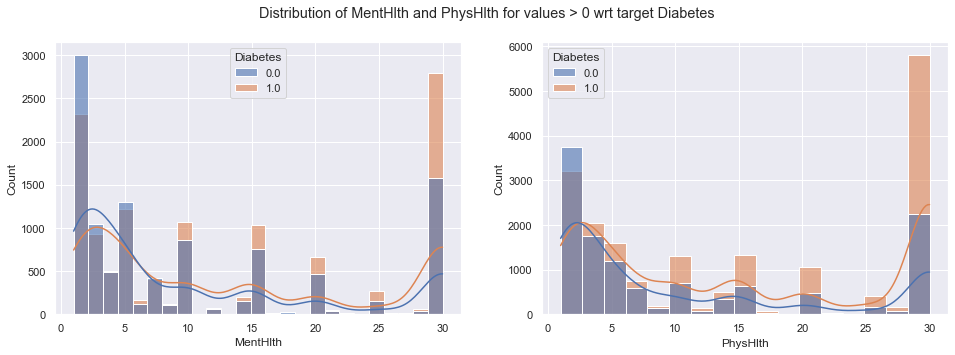

In [11]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Distribution of MentHlth and PhysHlth for values > 0 wrt target {}".format(targets[0]))
sns.histplot(data=df.loc[df['MentHlth']>0],x='MentHlth',hue=targets[0],kde=True,alpha=0.6,ax=ax[0])
ax[0].set_xlabel('MentHlth')
sns.histplot(data=df.loc[df['PhysHlth']>0],x='PhysHlth',hue=targets[0],kde=True,alpha=0.6,ax=ax[1])
ax[1].set_xlabel('PhysHlth')
plt.show()

#### "Regular" Distributed Numerical Columns

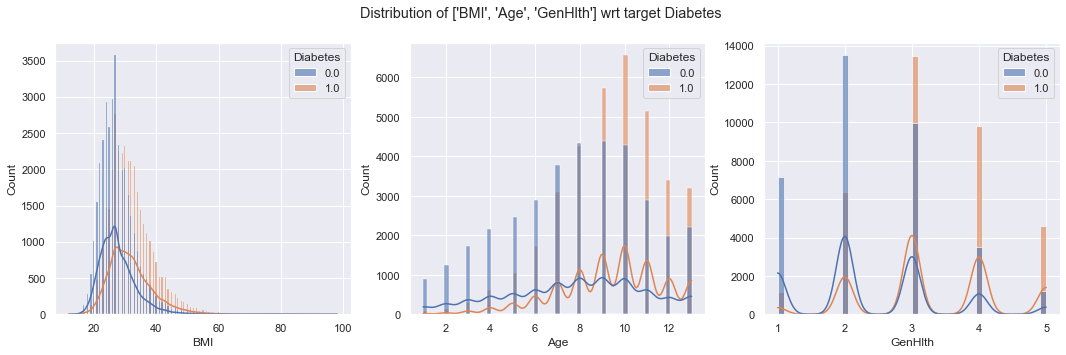

In [12]:
fig,ax=plt.subplots(1,3,figsize=(18,5))
plt.suptitle("Distribution of {} wrt target {}".format(num_reg,targets[0]))
for i in num_reg:
    sns.histplot(data=df,x=i,hue=targets[0],kde=True,alpha=0.6,ax=ax[num_reg.index(i)])
    ax[num_reg.index(i)].set_xlabel(i)
plt.show()

BMI is also skewed. For final model, I will use power transformer on BMI, MentHlth and PhysHlth. GenHlth and Age will be transformed by StandardScaler.

#### Categorical Columns

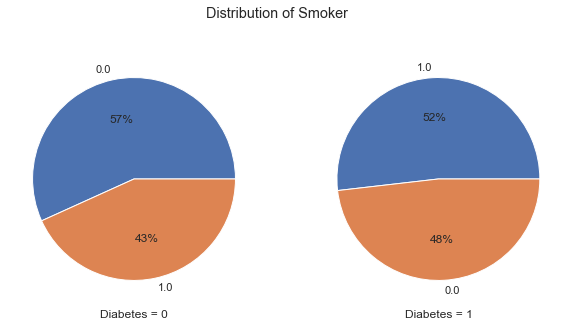

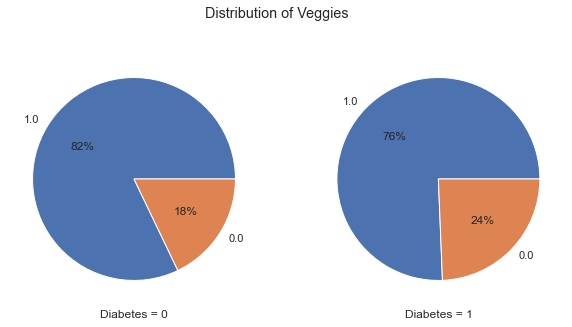

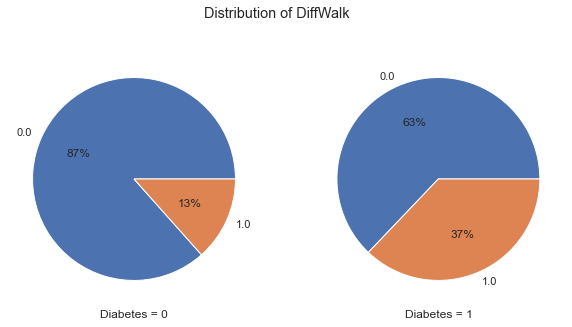

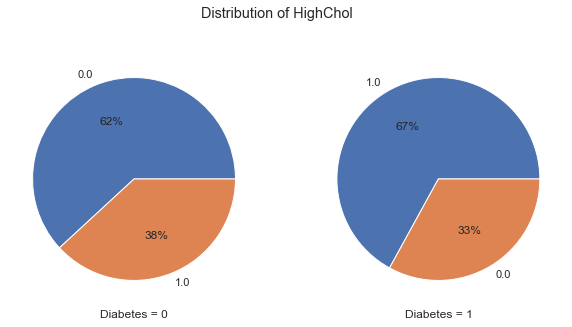

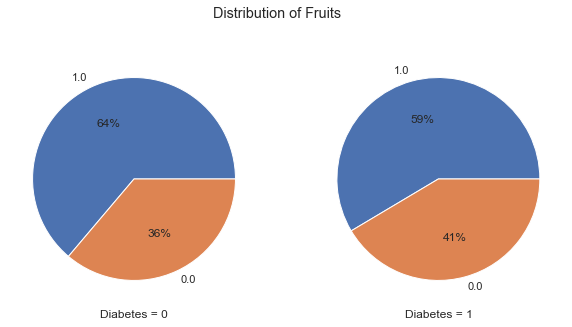

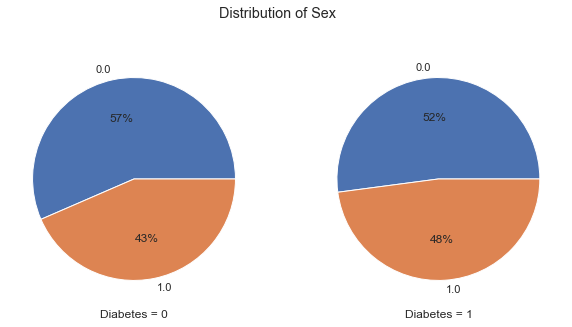

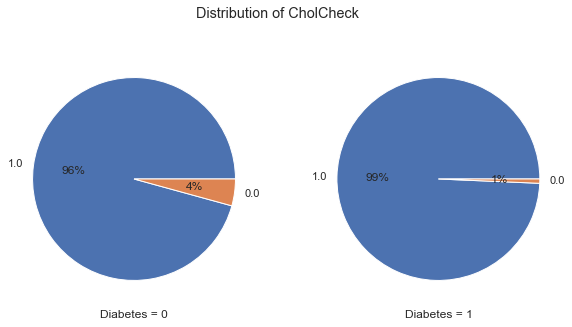

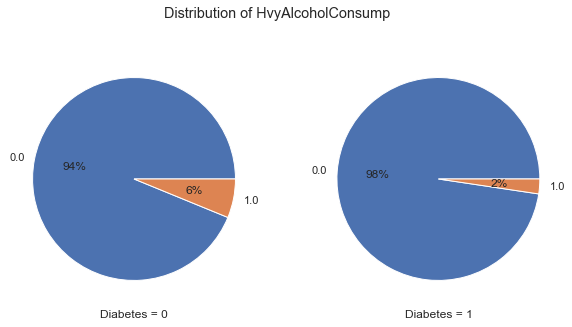

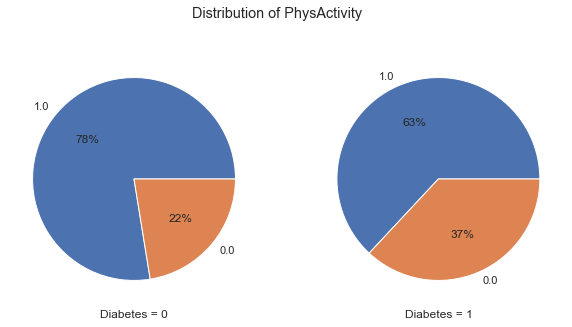

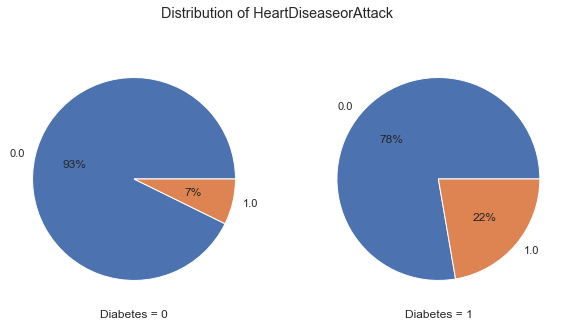

In [13]:
for i in cat_cols:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("Distribution of {}".format(i))
    ax[0].pie(df[i].loc[df[targets[0]]==0].value_counts(),labels=df[i].loc[df[targets[0]]==0].value_counts().index,autopct='%1.0f%%')
    ax[0].set_xlabel("{} = 0".format(targets[0]))
    ax[1].pie(df[i].loc[df[targets[0]]==1].value_counts(),labels=df[i].loc[df[targets[0]]==1].value_counts().index,autopct='%1.0f%%')
    ax[1].set_xlabel("{} = 1".format(targets[0]))
    plt.show()

There is difference in distribution of classes for the binary categories wrt target. This is encouraging. No column transformation required on these columns.<br>

### Analysis with respect to target Hypertension

#### Skewed Columns

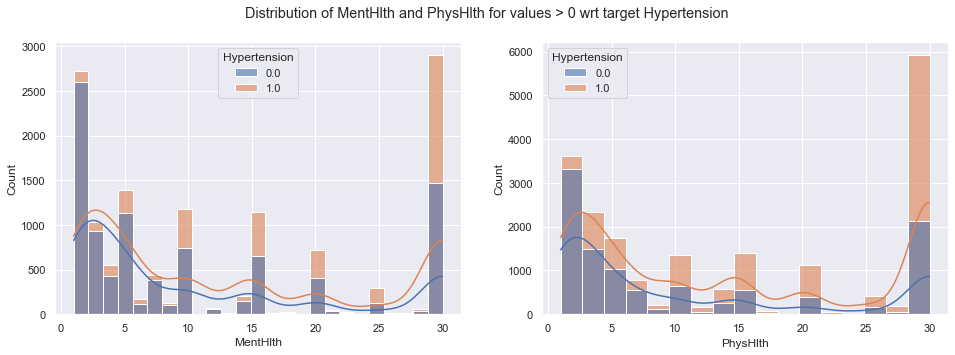

In [14]:
fig,ax=plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Distribution of MentHlth and PhysHlth for values > 0 wrt target {}".format(targets[1]))
sns.histplot(data=df.loc[df['MentHlth']>0],x='MentHlth',hue=targets[1],kde=True,alpha=0.6,ax=ax[0])
ax[0].set_xlabel('MentHlth')
sns.histplot(data=df.loc[df['PhysHlth']>0],x='PhysHlth',hue=targets[1],kde=True,alpha=0.6,ax=ax[1])
ax[1].set_xlabel('PhysHlth')
plt.show()

#### "Regular" Distributed Numerical Columns

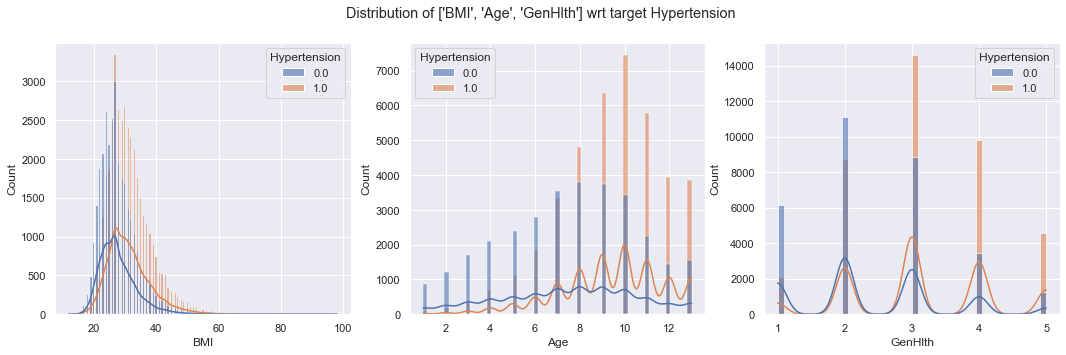

In [15]:
fig,ax=plt.subplots(1,3,figsize=(18,5))
plt.suptitle("Distribution of {} wrt target {}".format(num_reg,targets[1]))
for i in num_reg:
    sns.histplot(data=df,x=i,hue=targets[1],kde=True,alpha=0.6,ax=ax[num_reg.index(i)])
    ax[num_reg.index(i)].set_xlabel(i)
plt.show()

#### Categorical Columns

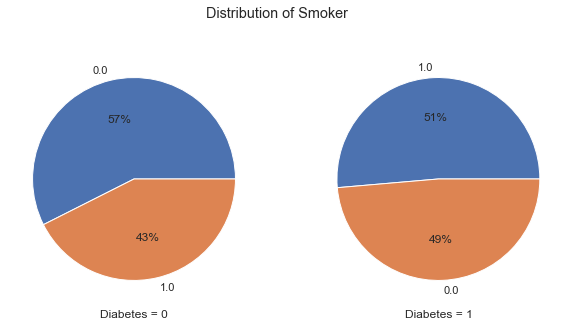

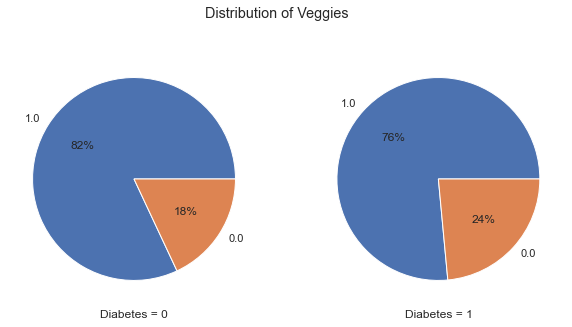

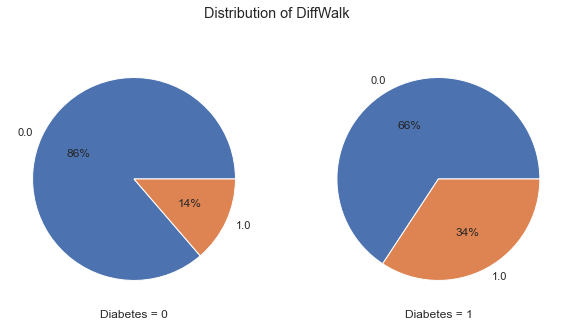

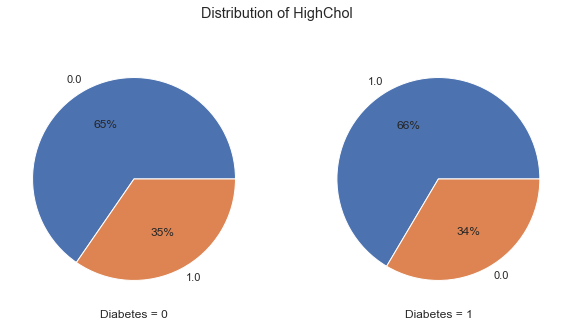

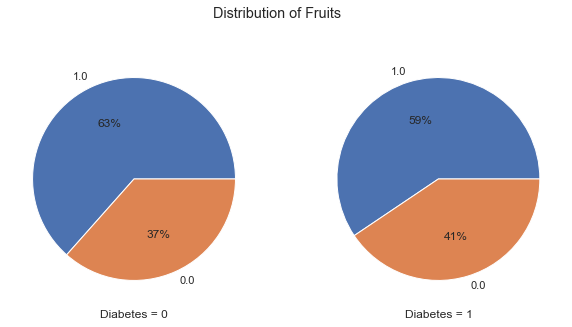

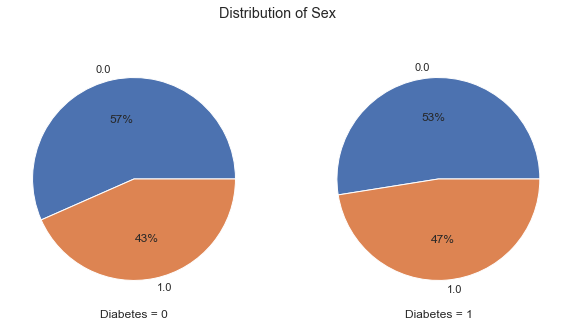

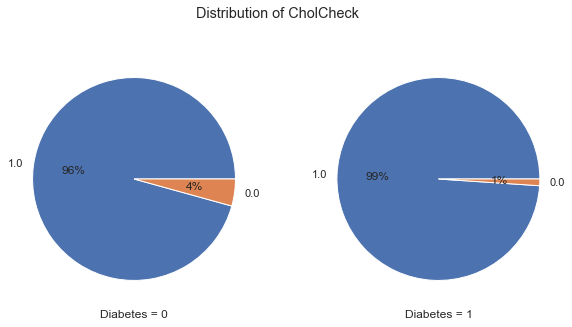

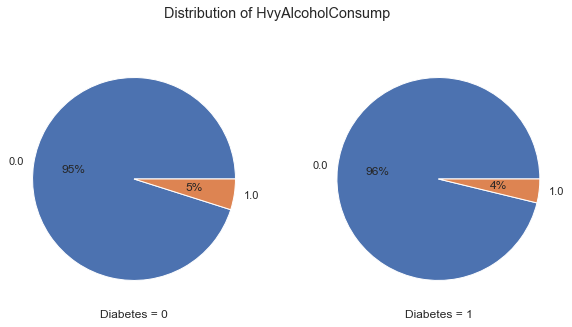

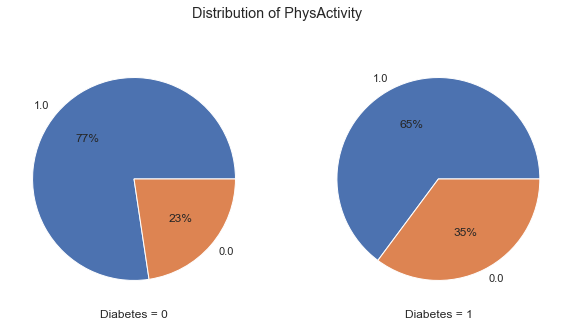

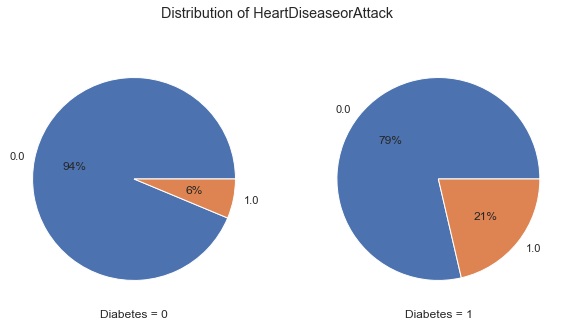

In [16]:
for i in cat_cols:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("Distribution of {}".format(i))
    ax[0].pie(df[i].loc[df[targets[1]]==0].value_counts(),labels=df[i].loc[df[targets[1]]==0].value_counts().index,autopct='%1.0f%%')
    ax[0].set_xlabel("{} = 0".format(targets[0]))
    ax[1].pie(df[i].loc[df[targets[1]]==1].value_counts(),labels=df[i].loc[df[targets[1]]==1].value_counts().index,autopct='%1.0f%%')
    ax[1].set_xlabel("{} = 1".format(targets[0]))
    plt.show()

### Analysis with respect to target Stroke

#### Skewed Columns
Since the dataset is highly imbalanced wrt Stroke (only 6% positive class), I will plot the distribution of the classes separately, so that the shape of the distribution of the minority class can be seen.

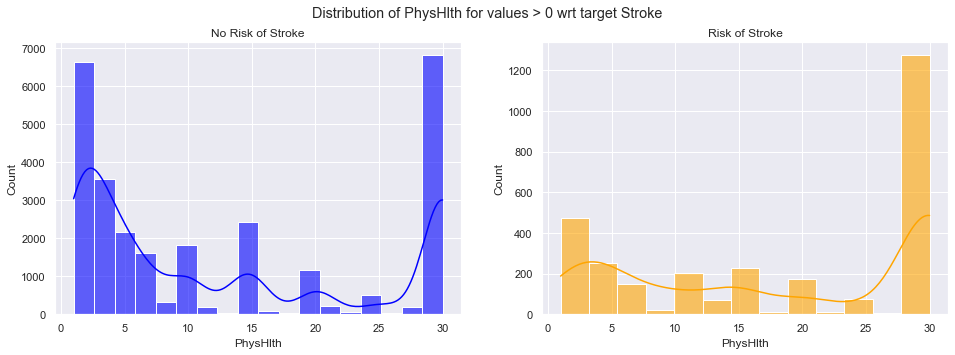

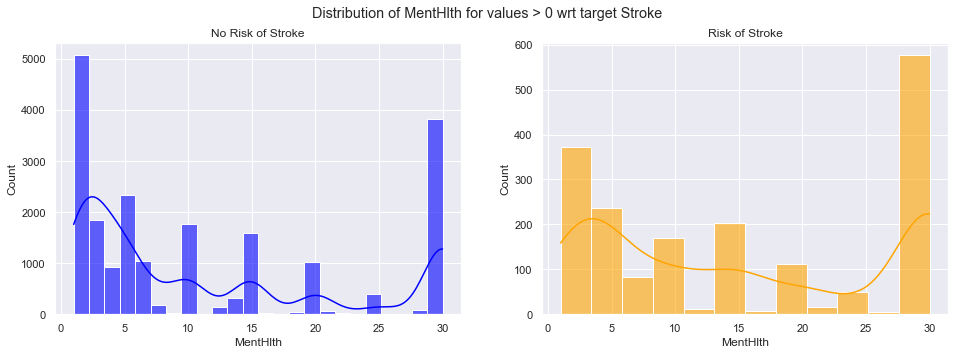

In [17]:
for i in num_skewed:
    fig,ax=plt.subplots(1,2,figsize=(16,5))
    plt.suptitle("Distribution of {} for values > 0 wrt target {}".format(i,targets[2]))
    sns.histplot(data=df.loc[(df[i]>0) & (df[targets[2]]==0)],x=i,kde=True,alpha=0.6,ax=ax[0],color='Blue')
    ax[0].set_xlabel(i)
    ax[0].set_title('No Risk of Stroke')
    sns.histplot(data=df.loc[(df[i]>0) & (df[targets[2]]==1)],x=i,kde=True,alpha=0.6,ax=ax[1],color='Orange')
    ax[1].set_xlabel(i)
    ax[1].set_title('Risk of Stroke')
    plt.show()

#### "Regular" Columns
Since the dataset is highly imbalanced wrt Stroke (only 6% positive class), I will plot the distribution of the classes separately, so that the shape of the distribution of the minority class can be seen.

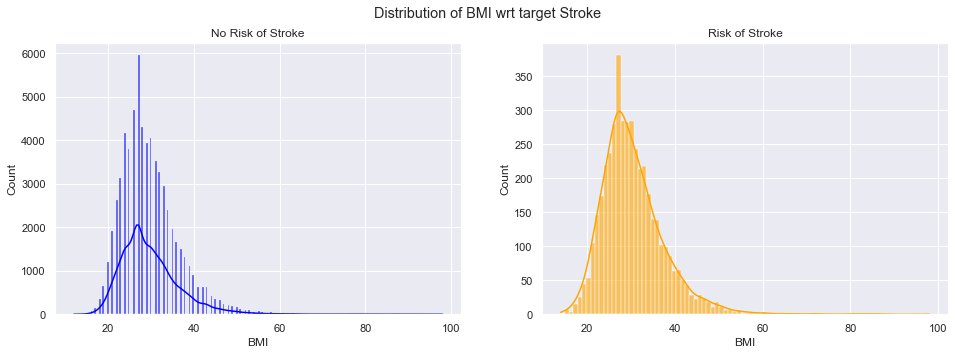

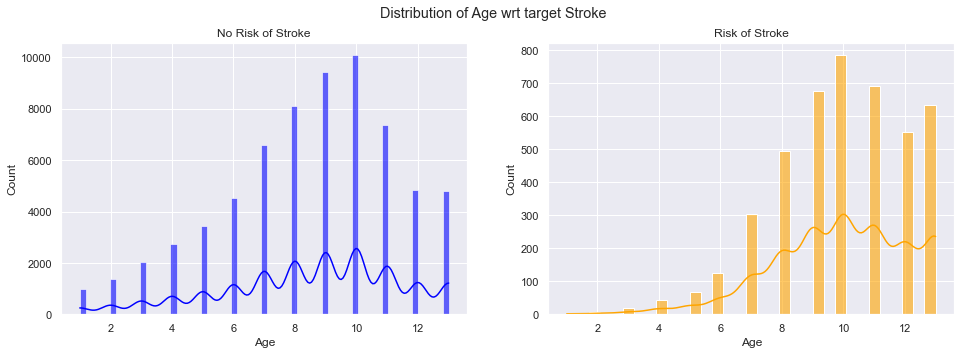

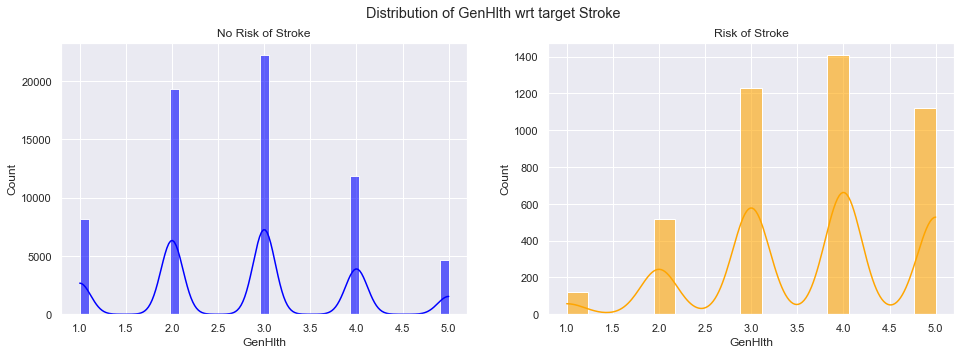

In [18]:
for i in num_reg:
    fig,ax=plt.subplots(1,2,figsize=(16,5))
    plt.suptitle("Distribution of {} wrt target {}".format(i,targets[2]))
    sns.histplot(data=df.loc[df[targets[2]]==0],x=i,kde=True,alpha=0.6,ax=ax[0],color='Blue')
    ax[0].set_xlabel(i)
    ax[0].set_title('No Risk of Stroke')
    sns.histplot(data=df.loc[df[targets[2]]==1],x=i,kde=True,alpha=0.6,ax=ax[1],color='Orange')
    ax[1].set_xlabel(i)
    ax[1].set_title('Risk of Stroke')
    plt.show()

#### Categorical Columns

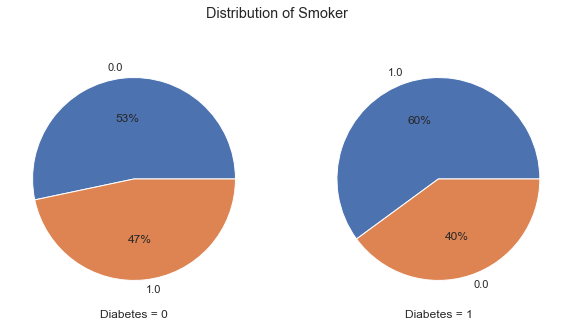

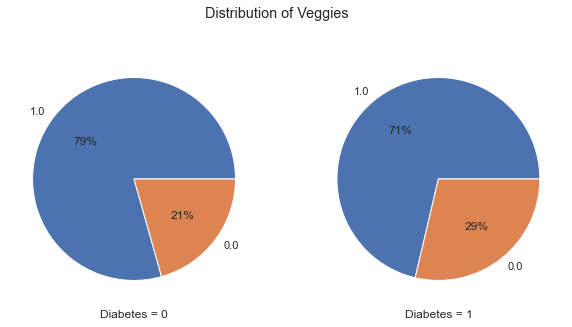

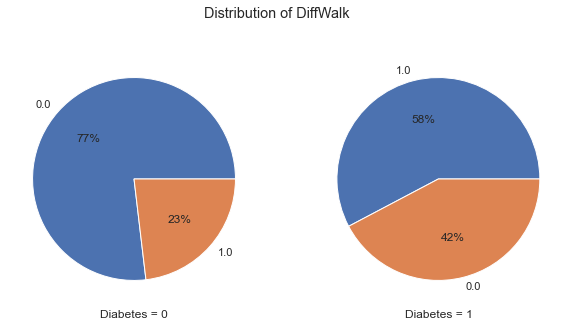

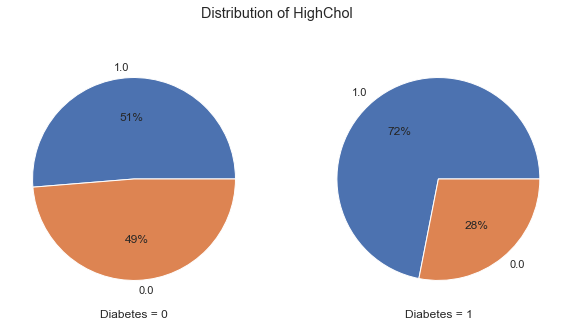

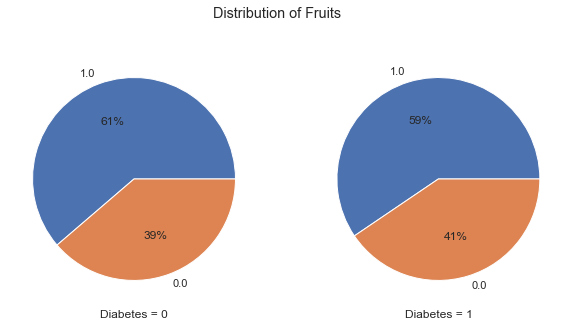

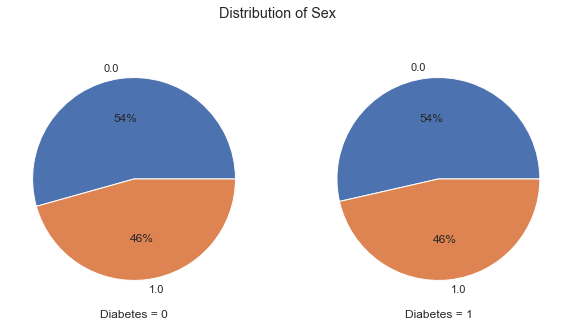

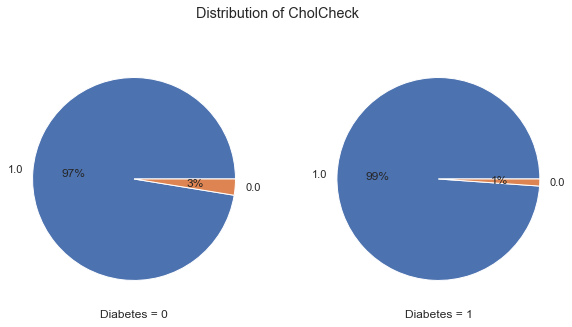

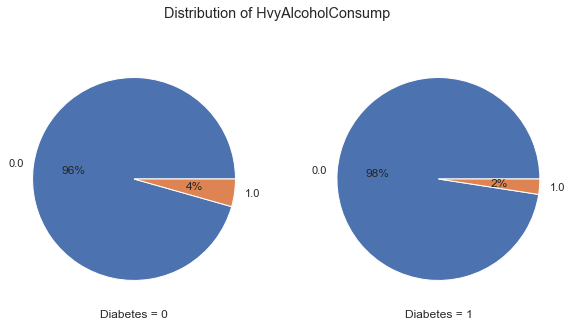

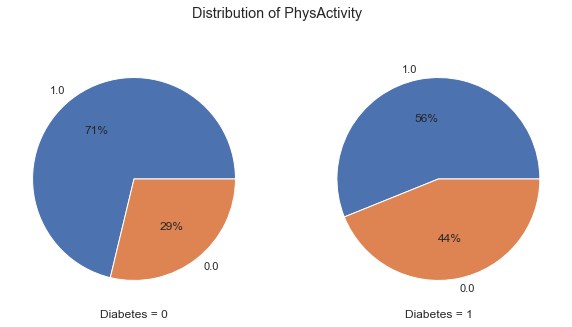

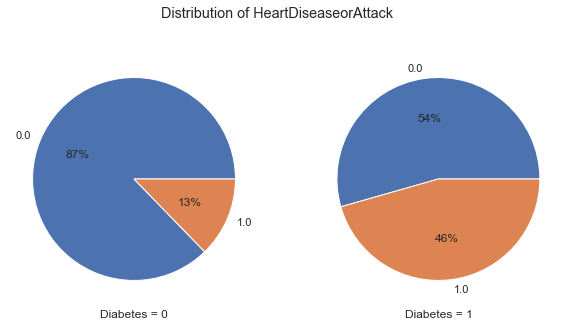

In [19]:
for i in cat_cols:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    plt.suptitle("Distribution of {}".format(i))
    ax[0].pie(df[i].loc[df[targets[2]]==0].value_counts(),labels=df[i].loc[df[targets[2]]==0].value_counts().index,autopct='%1.0f%%')
    ax[0].set_xlabel("{} = 0".format(targets[0]))
    ax[1].pie(df[i].loc[df[targets[2]]==1].value_counts(),labels=df[i].loc[df[targets[2]]==1].value_counts().index,autopct='%1.0f%%')
    ax[1].set_xlabel("{} = 1".format(targets[0]))
    plt.show()

### Observations

There is difference in distribution of features for the different classes of the targets for almost all the features. This should be theoretically easy to capture with machine learning models.

### Correlation Between Features

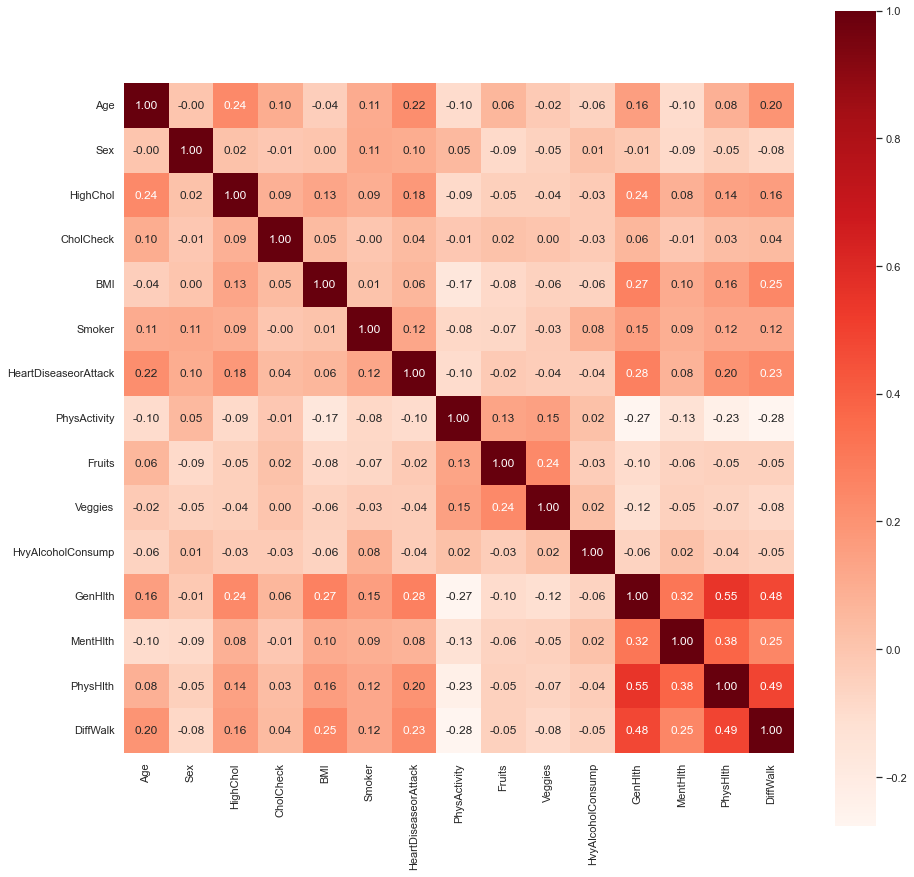

In [20]:
corr = df.drop(targets,axis=1).corr()
fig,ax=plt.subplots(figsize=(15,15))
sns.heatmap(corr,square=True,annot=True,cbar=True,cmap='Reds',fmt='0.2f',ax=ax)
plt.show()

GenHlth, MentHealth,PhysHlth,DiffWalk have significant correlation between themselves. Since there are indicators of health, its's not a surprise they are correlated. Looking closer, GenHlth, PhysHlth, DiffWalk are correlated to BMI, HeartDiseaseorAttack, BMI. This is something I would expect from "common sense".

### Correlation Between Targets

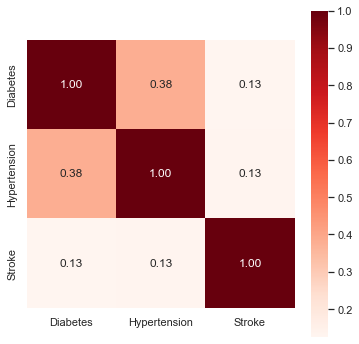

In [21]:
corr = df[targets].corr()
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(corr,square=True,annot=True,cbar=True,cmap='Reds',fmt='0.2f',ax=ax)
plt.show()

Diabetes and Hypertension are decently correlated.

### Training and Test Datasets

There is no need to scale the features as I will be using tree based models which do not require scaling.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(targets,axis=1),df[targets],test_size=0.2,random_state=2)

In [54]:
y_train_dia, y_test_dia = y_train[targets[0]],y_test[targets[0]] #diabetes targets
y_train_hyp, y_test_hyp = y_train[targets[1]],y_test[targets[1]] #hypertension targets
y_train_str, y_test_str = y_train[targets[2]],y_test[targets[2]] #stroke targets

### Training a Model to Fit target Diabetes

In [24]:
classifiers_dia = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(),
               CatBoostClassifier(verbose=False),XGBClassifier(),LGBMClassifier()]

scores_dia = pd.DataFrame(columns=['Classifier','Test-Recall','Train-Recall','Test-Accuracy','Train-Accuracy'])

for i in classifiers_dia:
    i.fit(X_train,y_train_dia)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    scores_dia.loc[scores_dia.shape[0]] = [i.__class__.__name__,recall_score(y_test_dia,y_pred_test),recall_score(y_train_dia,y_pred_train),
                                   accuracy_score(y_test_dia,y_pred_test),accuracy_score(y_train_dia,y_pred_train)]

[15:32:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
scores_dia.sort_values(by='Test-Recall',inplace=True)

In [26]:
scores_dia

,Classifier,Test-Recall,Train-Recall,Test-Accuracy,Train-Accuracy
0,DecisionTreeClassifier,0.642816,0.930812,0.662565,0.957420
1,RandomForestClassifier,0.756668,0.952770,0.718792,0.957420
2,AdaBoostClassifier,0.764697,0.761878,0.743405,0.741534
4,XGBClassifier,0.790794,0.817461,0.740929,0.771666
5,LGBMClassifier,0.795813,0.801706,0.745668,0.755345
3,CatBoostClassifier,0.797104,0.813372,0.745173,0.766219


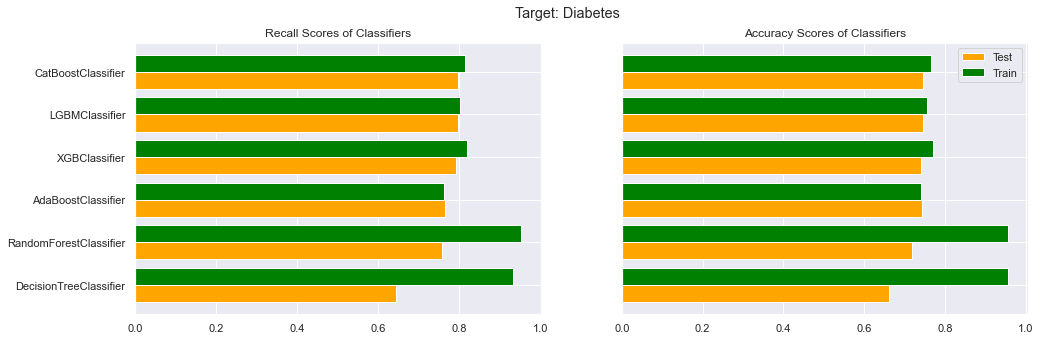

In [27]:
x = np.arange(scores_dia.shape[0])
width=0.4

fig,ax=plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Target: {}".format(targets[0]))
ax[0].barh(x-0.2,scores_dia['Test-Recall'],width,color='orange')
ax[0].barh(x+0.2,scores_dia['Train-Recall'],width,color='green')
ax[0].set_yticks(x,scores_dia['Classifier'])
ax[0].set_title('Recall Scores of Classifiers')

ax[1].barh(x-0.2,scores_dia['Test-Accuracy'],width,color='orange')
ax[1].barh(x+0.2,scores_dia['Train-Accuracy'],width,color='green')
ax[1].tick_params(left = False, bottom = False,labelleft = False )
ax[1].legend(['Test','Train'],bbox_to_anchor=(1,1))
ax[1].set_title('Accuracy Scores of Classifiers')
plt.show()

I tried hypterparameter tuning on CatBoost, but there wasn't any significant gain in the test recall score. I will go with the OOB CatBoost as my final model.

In [28]:
model_diabetes = classifiers_dia[3]

#### Feature Importance

In [29]:
feat_imp_sorted_dia = np.flip(np.sort(model_diabetes.feature_importances_))
feat_imp_sorted_args_dia = np.flip(np.argsort(model_diabetes.feature_importances_))
feat_names_sorted_dia = X_train.columns[feat_imp_sorted_args_dia]

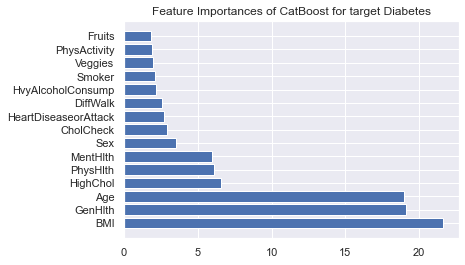

In [30]:
plt.barh(feat_names_sorted_dia,feat_imp_sorted_dia)
plt.title("Feature Importances of CatBoost for target Diabetes")
plt.show()

### Training a Model to Fit target Hypertension

In [31]:
classifiers_hyp = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(),
               CatBoostClassifier(verbose=False),XGBClassifier(),LGBMClassifier()]

scores_hyp = pd.DataFrame(columns=['Classifier','Test-Recall','Train-Recall','Test-Accuracy','Train-Accuracy'])

for i in classifiers_hyp:
    i.fit(X_train,y_train_hyp)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    scores_hyp.loc[scores_hyp.shape[0]] = [i.__class__.__name__,recall_score(y_test_hyp,y_pred_test),recall_score(y_train_hyp,y_pred_train),
                                   accuracy_score(y_test_hyp,y_pred_test),accuracy_score(y_train_hyp,y_pred_train)]

[15:33:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
scores_hyp.sort_values(by='Test-Recall',inplace=True)

In [33]:
scores_hyp

,Classifier,Test-Recall,Train-Recall,Test-Accuracy,Train-Accuracy
0,DecisionTreeClassifier,0.659532,0.938037,0.638942,0.953902
1,RandomForestClassifier,0.780282,0.960238,0.707971,0.953902
2,AdaBoostClassifier,0.809494,0.813421,0.736474,0.735010
4,XGBClassifier,0.820448,0.845814,0.736120,0.763602
5,LGBMClassifier,0.826240,0.835434,0.739939,0.746238
3,CatBoostClassifier,0.827751,0.844873,0.739090,0.757873


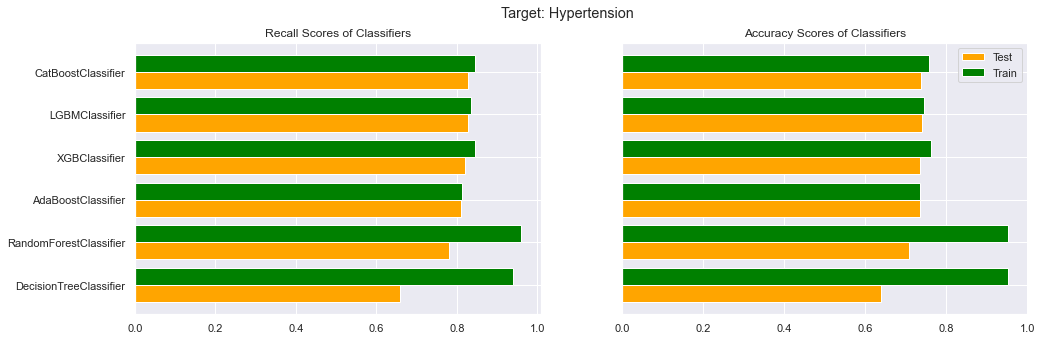

In [34]:
x = np.arange(scores_hyp.shape[0])
width=0.4

fig,ax=plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Target: {}".format(targets[1]))
ax[0].barh(x-0.2,scores_hyp['Test-Recall'],width,color='orange')
ax[0].barh(x+0.2,scores_hyp['Train-Recall'],width,color='green')
ax[0].set_yticks(x,scores_hyp['Classifier'])
ax[0].set_title('Recall Scores of Classifiers')

ax[1].barh(x-0.2,scores_hyp['Test-Accuracy'],width,color='orange')
ax[1].barh(x+0.2,scores_hyp['Train-Accuracy'],width,color='green')
ax[1].tick_params(left = False, bottom = False,labelleft = False )
ax[1].legend(['Test','Train'],bbox_to_anchor=(1,1))
ax[1].set_title('Accuracy Scores of Classifiers')
plt.show()

Recall score of CatBoost is good enough for me. I won't bother with hyper-parameter tuning. 

In [35]:
model_hypertension = classifiers_hyp[3]

#### Feature Importance

In [36]:
feat_imp_sorted_hyp = np.flip(np.sort(model_hypertension.feature_importances_))
feat_imp_sorted_args_hyp = np.flip(np.argsort(model_hypertension.feature_importances_))
feat_names_sorted_hyp = X_train.columns[feat_imp_sorted_args_hyp]

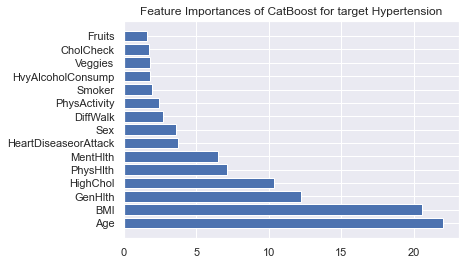

In [37]:
plt.barh(feat_names_sorted_hyp,feat_imp_sorted_hyp)
plt.title("Feature Importances of CatBoost for target Hypertension")
plt.show()

### Training a Model to Fit target Stroke

This is a more crucial target, in my opinion. Since the class imbalance is significant, I expect the model recall to be poor.

In [38]:
classifiers_str = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(),
               CatBoostClassifier(verbose=False),XGBClassifier(),LGBMClassifier()]

scores_str = pd.DataFrame(columns=['Classifier','Test-Recall','Train-Recall','Test-Accuracy','Train-Accuracy'])

for i in classifiers_str:
    i.fit(X_train,y_train_str)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    scores_str.loc[scores_str.shape[0]] = [i.__class__.__name__,recall_score(y_test_str,y_pred_test),recall_score(y_train_str,y_pred_train),
                                   accuracy_score(y_test_str,y_pred_test),accuracy_score(y_train_str,y_pred_train)]

[15:34:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
scores_str.sort_values(by='Test-Recall',inplace=True)

In [40]:
scores_str

,Classifier,Test-Recall,Train-Recall,Test-Accuracy,Train-Accuracy
5,LGBMClassifier,0.002457,0.016197,0.942358,0.937669
3,CatBoostClassifier,0.013514,0.091874,0.941156,0.942107
2,AdaBoostClassifier,0.014742,0.008657,0.942358,0.936484
4,XGBClassifier,0.020885,0.107233,0.940802,0.942797
1,RandomForestClassifier,0.025799,0.911756,0.936134,0.993793
0,DecisionTreeClassifier,0.187961,0.905054,0.890303,0.993846


Very poor performance, and high level of overfitting. Let me up-sample the minority class.

#### Upsampling the Minority Class and Downsampling the Majority Class

In [41]:
traindf = pd.concat([X_train,pd.DataFrame(y_train_str)],axis=1)

n0, n1 = traindf[targets[2]].value_counts() #number of instances in each class

class0 = traindf[traindf[targets[2]]==0]
class1 = traindf[traindf[targets[2]]==1]

In [63]:
n=10
f=0.7
n*n1/(n*n1+f*n0)

0.49128554651915757

Taking $10n_1$ samples of class 1, and $int(0.7n_0)$ samples of class 0 gives roughly equal class distributions.

In [64]:
print("Before Resampling")
print("Fraction of Class 0: {}".format(n0/(n0+n1))) 
print("Fraction of Class 1: {}".format(n1/(n0+n1)))

class1over = class1.sample(10*n1,replace=True) 
class0under = class0.sample(int(0.7*n0),replace=False)
overdf = pd.concat([class0under,class1over],axis=0).sample(frac=1)

print("After Resampling")
print("Fraction of Class 0: {}".format(overdf[targets[2]].value_counts()[0]/overdf[targets[2]].value_counts().sum()))
print("Fraction of Class 1: {}".format(overdf[targets[2]].value_counts()[1]/overdf[targets[2]].value_counts().sum()))

Before Resampling
Fraction of Class 0: 0.9366788676109137
Fraction of Class 1: 0.06332113238908635
After Resampling
Fraction of Class 0: 0.5087117574427219
Fraction of Class 1: 0.4912882425572781


In [65]:
X_train, y_train_str = overdf.drop(targets[2],axis=1),overdf[targets[2]]

#### Re-training

In [66]:
classifiers_str = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(),
               CatBoostClassifier(verbose=False),XGBClassifier(),LGBMClassifier()]

scores_str = pd.DataFrame(columns=['Classifier','Test-Recall','Train-Recall','Test-Accuracy','Train-Accuracy'])

for i in classifiers_str:
    i.fit(X_train,y_train_str)
    y_pred_test = i.predict(X_test)
    y_pred_train = i.predict(X_train)
    scores_str.loc[scores_str.shape[0]] = [i.__class__.__name__,recall_score(y_test_str,y_pred_test),recall_score(y_train_str,y_pred_train),
                                   accuracy_score(y_test_str,y_pred_test),accuracy_score(y_train_str,y_pred_train)]

[17:09:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
scores_str.sort_values(by='Test-Recall',inplace=True)

In [68]:
scores_str

,Classifier,Test-Recall,Train-Recall,Test-Accuracy,Train-Accuracy
1,RandomForestClassifier,0.144963,0.999497,0.906783,0.993209
0,DecisionTreeClassifier,0.194103,0.999246,0.868025,0.993209
4,XGBClassifier,0.588452,0.861212,0.765188,0.831266
3,CatBoostClassifier,0.593366,0.857945,0.762147,0.827452
2,AdaBoostClassifier,0.692875,0.697794,0.736898,0.719070
5,LGBMClassifier,0.721130,0.834013,0.724238,0.782947


That is some serious improvement. With the original dataset, the best test-recall-score (DecisionTree) was 18%, and now the best test-recall-score (LGBMClassifier) is 72%. DecisionTree hasn't improved much from the up/down-sampling. LGBMClassifier has improved from an abysmal 0.2% (worst model) to 72% (best model).

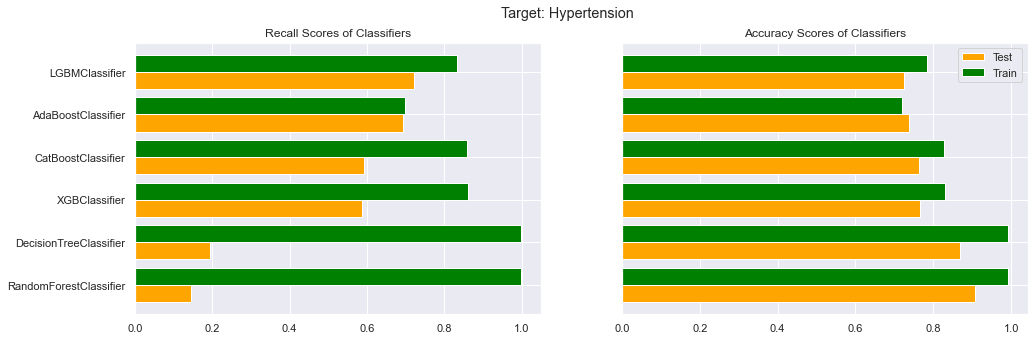

In [69]:
x = np.arange(scores_str.shape[0])
width=0.4

fig,ax=plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Target: {}".format(targets[1]))
ax[0].barh(x-0.2,scores_str['Test-Recall'],width,color='orange')
ax[0].barh(x+0.2,scores_str['Train-Recall'],width,color='green')
ax[0].set_yticks(x,scores_str['Classifier'])
ax[0].set_title('Recall Scores of Classifiers')

ax[1].barh(x-0.2,scores_str['Test-Accuracy'],width,color='orange')
ax[1].barh(x+0.2,scores_str['Train-Accuracy'],width,color='green')
ax[1].tick_params(left = False, bottom = False,labelleft = False )
ax[1].legend(['Test','Train'],bbox_to_anchor=(1,1))
ax[1].set_title('Accuracy Scores of Classifiers')
plt.show()

In [70]:
model_stroke = classifiers_str[5]

#### Feature Importance

In [77]:
feat_imp_sorted_str = np.flip(np.sort(model_stroke.feature_importances_))
feat_imp_sorted_args_str = np.flip(np.argsort(model_stroke.feature_importances_))
feat_names_sorted_str = X_train.columns[feat_imp_sorted_args_str]

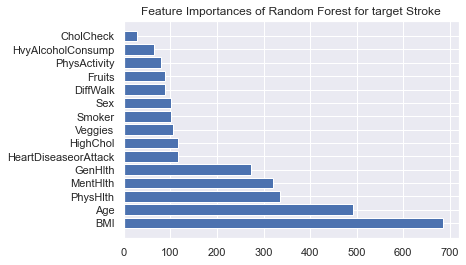

In [78]:
plt.barh(feat_names_sorted_str,feat_imp_sorted_str)
plt.title("Feature Importances of Random Forest for target Stroke")
plt.show()

#### Comparing Feature importances across Targets

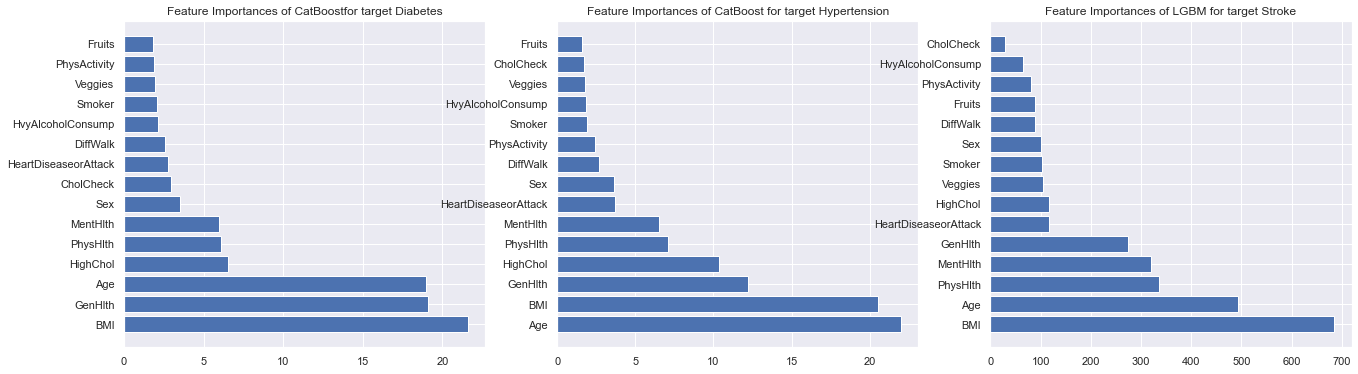

In [80]:
fig, ax = plt.subplots(1,3,figsize=(22,6))
ax[0].barh(feat_names_sorted_dia,feat_imp_sorted_dia)
ax[0].set_title("Feature Importances of CatBoostfor target Diabetes")
ax[1].barh(feat_names_sorted_hyp,feat_imp_sorted_hyp)
ax[1].set_title("Feature Importances of CatBoost for target Hypertension")
ax[2].barh(feat_names_sorted_str,feat_imp_sorted_str)
ax[2].set_title("Feature Importances of LGBM for target Stroke")
plt.show()

In [81]:
pickle.dump(model_diabetes,open('model_dia.pkl','wb'))
pickle.dump(model_hypertension,open('model_hyp.pkl','wb'))
pickle.dump(model_stroke,open('model_str.pkl','wb'))

For all three targets, BMI, Age, General Health, and Physical Health are in the top 5 important features.